In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
from geographiclib.geodesic import Geodesic
import os

In [2]:
# Extract data from the csv
csv_path = r'C:\Users\Jonathan van Zyl\Documents\GitHub\paparazzi\COMPUTERVISIONSIM\Projection\single_image\20190121-140303.csv'

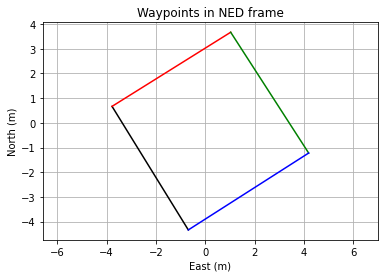

In [3]:
'''
course_orangeavoid_cyberzoo_guided.xml
lat0="51.990634" lon0="4.376789"
    <waypoint lat="51.990595" lon="4.376779" name="_OZ1"/>
    <waypoint lat="51.990640" lon="4.376734" name="_OZ2"/>
    <waypoint lat="51.990667" lon="4.376804" name="_OZ3"/>
    <waypoint lat="51.990623" lon="4.376850" name="_OZ4"/>

'''
# Base coordinates (lat0, lon0)
lat0, lon0 = 51.990634, 4.376789

# Waypoint coordinates
waypoints = [
    {"lat": 51.990595, "lon": 4.376779, "name": "_OZ1"},
    {"lat": 51.990640, "lon": 4.376734, "name": "_OZ2"},
    {"lat": 51.990667, "lon": 4.376804, "name": "_OZ3"},
    {"lat": 51.990623, "lon": 4.376850, "name": "_OZ4"}
]

# Geodesic object for calculations
geod = Geodesic.WGS84

# Convert each waypoint to XYZ in NED frame
xyz_coordinates = []
for waypoint in waypoints:
    g = geod.Inverse(lat0, lon0, waypoint["lat"], waypoint["lon"])
    
    # Calculate the north, east distances based on the azimuth and distance
    # Assuming a flat Earth approximation for small distances
    north = g['s12'] * np.cos(np.radians(g['azi1']))
    east = g['s12'] * np.sin(np.radians(g['azi1']))
    # Assuming height (down) is 0 for all waypoints as it's not provided
    down = 0
    
    xyz_coordinates.append({"name": waypoint["name"], "x": east, "y": north, "z": down})

OZ1_cyberzoo = np.array([[xyz["x"], xyz["y"], xyz["z"]] for xyz in xyz_coordinates if xyz["name"] == "_OZ1"])
OZ2_cyberzoo = np.array([[xyz["x"], xyz["y"], xyz["z"]] for xyz in xyz_coordinates if xyz["name"] == "_OZ2"])
OZ3_cyberzoo = np.array([[xyz["x"], xyz["y"], xyz["z"]] for xyz in xyz_coordinates if xyz["name"] == "_OZ3"])
OZ4_cyberzoo = np.array([[xyz["x"], xyz["y"], xyz["z"]] for xyz in xyz_coordinates if xyz["name"] == "_OZ4"])

#1 -> 2 : Black
#2 -> 3 : Red
#3 -> 4 : White
#4 -> 1 : Blue

# Plot lines between waypoints
plt.figure()
plt.plot([OZ1_cyberzoo[0,0], OZ2_cyberzoo[0,0]], [OZ1_cyberzoo[0,1], OZ2_cyberzoo[0,1]], 'k-')
plt.plot([OZ2_cyberzoo[0,0], OZ3_cyberzoo[0,0]], [OZ2_cyberzoo[0,1], OZ3_cyberzoo[0,1]], 'r-')
plt.plot([OZ3_cyberzoo[0,0], OZ4_cyberzoo[0,0]], [OZ3_cyberzoo[0,1], OZ4_cyberzoo[0,1]], 'g-')
plt.plot([OZ4_cyberzoo[0,0], OZ1_cyberzoo[0,0]], [OZ4_cyberzoo[0,1], OZ1_cyberzoo[0,1]], 'b-')

plt.xlabel("East (m)")
plt.ylabel("North (m)")
plt.title("Waypoints in NED frame")
# make axis 1 to 1
plt.axis('equal')
plt.grid()
plt.show()


In [4]:
# Extract time using pandas
def image_data_needed(time_step, csv_path):
    df = pd.read_csv(csv_path)
    time = df['time']
    pos_x = df['pos_x']
    pos_y = df['pos_y']
    pos_z = df['pos_z']
    att_phi = df['att_phi']
    att_theta = df['att_theta']
    att_psi = df['att_psi']

    # Interpolate the data with respect to the time stamp
    index = np.argmin(np.abs(time - time_step))

    # Extract the position and attitude at the time stamp
    pos_x = pos_x[index]
    pos_y = pos_y[index]
    pos_z = pos_z[index]
    att_phi = att_phi[index]
    att_theta = att_theta[index]
    att_psi = att_psi[index]

    # make state vector
    state_vector = np.array([pos_x, pos_y, pos_z, att_phi, att_theta, att_psi])

    # Rotation matrix wrt to cyberzoo frame to drone frame
    def update_camera_rotation_matrix(psi):
                # Converting from [-pi, pi] to [0, 2pi]:
                if psi < 0:
                    yaw = 2 * np.pi + psi
                else:
                    yaw = psi
                Rz = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                            [np.sin(yaw), np.cos(yaw), 0],
                            [0, 0, 1]])

                # The order of multiplication depends on the convention used. This uses ZYX (yaw-pitch-roll).
                R = Rz

                return R

    '''
    _OZ1: X=-1.34 m, Y=-3.37 m, Z=0 m
    _OZ2: X=-4.40 m, Y=1.05 m, Z=0 m
    _OZ3: X=0.44 m, Y=4.18 m, Z=0 m
    _OZ4: X=3.27 m, Y=-0.41 m, Z=0 m
    '''

    # Define the corners of the cyberzoo in Cyberzoo frame
    #OZ1_cyberzoo = np.array([-1.34, -3.37, 0])
    #OZ2_cyberzoo = np.array([-4.40, 1.05, 0])
    #OZ3_cyberzoo = np.array([0.44, 4.18, 0])
    #OZ4_cyberzoo = np.array([3.27, -0.41, 0])
    OZ1_cyberzoo = np.array([-0.68692408, -4.33941978, 0])
    OZ2_cyberzoo = np.array([-3.77807863, 0.66760448, 0])
    OZ3_cyberzoo = np.array([1.03038446, 3.6718169, 0])
    OZ4_cyberzoo = np.array([4.19023425, -1.22393717, 0])

    # Rotate & translate the corners into the drone frame
    R = update_camera_rotation_matrix(att_psi)
    #R = np.linalg.inv(R)
    t = np.array([pos_x, pos_y, pos_z])
    OZ1 = np.dot(R, OZ1_cyberzoo) - t
    OZ2 = np.dot(R, OZ2_cyberzoo) - t
    OZ3 = np.dot(R, OZ3_cyberzoo) - t
    OZ4 = np.dot(R, OZ4_cyberzoo) - t

    return OZ1, OZ2, OZ3, OZ4, state_vector, OZ1_cyberzoo, OZ2_cyberzoo, OZ3_cyberzoo, OZ4_cyberzoo

rvec_null = np.zeros((1, 1, 3), dtype=np.float32)
Tvec_null = np.zeros((1, 1, 3), dtype=np.float32)

In [5]:
image_path_a = r'C:\Users\Jonathan van Zyl\Documents\GitHub\paparazzi\COMPUTERVISIONSIM\Projection\single_image\image\68016093.jpg'
time_stamp_a = 68.016093

image_path_b = r'C:\Users\Jonathan van Zyl\Documents\GitHub\paparazzi\COMPUTERVISIONSIM\Projection\single_image\image\73649375.jpg'
time_stamp_b = 73.649375

image_path_b = r'C:\Users\Jonathan van Zyl\Documents\GitHub\paparazzi\COMPUTERVISIONSIM\Projection\single_image\image\85649285.jpg'
time_stamp_b = 85.649285

image_path_c = r'C:\Users\Jonathan van Zyl\Documents\GitHub\paparazzi\COMPUTERVISIONSIM\Projection\single_image\image\80149330.jpg'
time_stamp_c = 80.149330

#image_path_c = r'C:\Users\Jonathan van Zyl\Documents\GitHub\paparazzi\COMPUTERVISIONSIM\Projection\single_image\image\80749322.jpg'
#time_stamp_c = 80.749322

image_path_d = r'C:\Users\Jonathan van Zyl\Documents\GitHub\paparazzi\COMPUTERVISIONSIM\Projection\single_image\image\63582791.jpg'
time_stamp_d = 63.582791




In [6]:
# Function to project points and update the image based on camera parameters
def update_image(f_x, f_y, c_x, c_y, image_path, time_step, csv_path, axes, corner_of_interest_idx = 1, padding = 150):
    # Define the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Rotate image
    image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)

    OZ1, OZ2, OZ3, OZ4, state_vector, OZ1_cyberzoo, OZ2_cyberzoo, OZ3_cyberzoo, OZ4_cyberzoo =  image_data_needed(time_step, csv_path)

    # MAKE PLOT TITLE
    if corner_of_interest_idx == 1:
        OZ_title_cyberzoo = OZ1_cyberzoo
    elif corner_of_interest_idx == 2:
        OZ_title_cyberzoo = OZ2_cyberzoo
    elif corner_of_interest_idx == 3:
        OZ_title_cyberzoo = OZ3_cyberzoo
    elif corner_of_interest_idx == 4:
        OZ_title_cyberzoo = OZ4_cyberzoo

    # Extract states from state vector & round to 2 decimal places
    pos_x = state_vector[0]
    pos_y = state_vector[1]
    pos_z = state_vector[2]
    pos_x = round(pos_x, 2)
    pos_y = round(pos_y, 2)
    pos_z = round(pos_z, 2)
    att_phi = state_vector[3] * 180 / np.pi
    att_theta = state_vector[4] * 180 / np.pi
    att_psi = state_vector[5] * 180 / np.pi
    # Round angles to 2 significant figures
    att_phi = round(att_phi, 2)
    att_theta = round(att_theta, 2)
    att_psi = round(att_psi, 2)

    # Make plot title line wrt to the state vector include all states
    plot_title = 'Drones posiition wrt Cyberzoo frame : N: ' + str(pos_x) + ' E: ' + str(pos_y) + ' D: ' + str(pos_z) + '\n' + chr(0x03C8) + ': ' + str(att_psi) + ' ' + chr(0x03B8) + ': ' + str(att_theta) + ' ' + chr(0x03C6) + ': ' + str(att_phi) + '\n Cyberzoo Frame Corner of Interest : N: ' + str(OZ_title_cyberzoo[0]) + ' E: ' + str(OZ_title_cyberzoo[1]) + ' D: ' + str(OZ_title_cyberzoo[2])
    
    def xy_projections(x, y, z, f_x, f_y, c_x, c_y):
        x_norm = y / x
        y_norm = z / x
        x_prime = f_x * x_norm + c_x
        y_prime = f_y * y_norm + c_y
        return x_prime, y_prime

    # Copy the original image so as not to overwrite it
    updated_image = np.copy(image)

    # Add padding to the image
    updated_image = cv2.copyMakeBorder(updated_image, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=[255, 255, 255])    
    

    
    # Draw the interpolated points
    # Interpolate points between the corners
    num_points = 20
    x_values = np.linspace(OZ1[0], OZ2[0], num_points)
    y_values = np.linspace(OZ1[1], OZ2[1], num_points)
    z_values = np.linspace(OZ1[2], OZ2[2], num_points)
    for i in range(num_points):
        x_prime, y_prime = xy_projections(x_values[i], y_values[i], z_values[i], f_x, f_y, c_x, c_y)
        # Make sure the points are integers
        x_prime = int(x_prime)
        y_prime = int(y_prime)
        # Correct for padding
        x_prime += padding
        y_prime += padding
        
        cv2.circle(updated_image, (x_prime, y_prime), 5, (0, 0, 0), -1) # Black : (0, 0, 0)

    num_points = 20
    x_values = np.linspace(OZ2[0], OZ3[0], num_points)
    y_values = np.linspace(OZ2[1], OZ3[1], num_points)
    z_values = np.linspace(OZ2[2], OZ3[2], num_points)
    for i in range(num_points):
        x_prime, y_prime = xy_projections(x_values[i], y_values[i], z_values[i], f_x, f_y, c_x, c_y)
        # Make sure the points are integers
        x_prime = int(x_prime)
        y_prime = int(y_prime)
        # Correct for padding
        x_prime += padding
        y_prime += padding
        cv2.circle(updated_image, (x_prime, y_prime), 5, (0, 0, 225), -1) # Red : (0, 0, 255)
    num_points = 20
    x_values = np.linspace(OZ1[0], OZ4[0], num_points)
    y_values = np.linspace(OZ1[1], OZ4[1], num_points)
    z_values = np.linspace(OZ1[2], OZ4[2], num_points)
    for i in range(num_points):
        x_prime, y_prime = xy_projections(x_values[i], y_values[i], z_values[i], f_x, f_y, c_x, c_y)
        # Make sure the points are integers
        x_prime = int(x_prime)
        y_prime = int(y_prime)
        # Correct for padding
        x_prime += padding
        y_prime += padding
        #print('x_prime: ', x_prime, 'y_prime: ', y_prime)
        cv2.circle(updated_image, (x_prime, y_prime), 5, (0, 255, 0), -1)  # Green : (0, 255, 0)
    num_points = 20
    x_values = np.linspace(OZ3[0], OZ4[0], num_points)
    y_values = np.linspace(OZ3[1], OZ4[1], num_points)
    z_values = np.linspace(OZ3[2], OZ4[2], num_points)
    for i in range(num_points):
        x_prime, y_prime = xy_projections(x_values[i], y_values[i], z_values[i], f_x, f_y, c_x, c_y)
        # Make sure the points are integers
        x_prime = int(x_prime)
        y_prime = int(y_prime)
        # Correct for padding
        x_prime += padding
        y_prime += padding
        cv2.circle(updated_image, (x_prime, y_prime), 5, (255, 0, 0), -1) # Blue : (255, 0, 0)

    
    # Display the updated image
    axes.imshow(updated_image)
    axes.set_title(plot_title)


def all_images_update(f_x, f_y, c_x, c_y, image_path_a, time_stamp_a, image_path_b, time_stamp_b, image_path_c, time_stamp_c, image_path_d, time_stamp_d, csv_path):
    fig, axs = plt.subplots(2, 2, figsize=(25, 25))
    update_image(f_x, f_y, c_x, c_y, image_path_a, time_stamp_a, csv_path, axs[0, 0], corner_of_interest_idx = 1)
    update_image(f_x, f_y, c_x, c_y, image_path_b, time_stamp_b, csv_path, axs[0, 1], corner_of_interest_idx = 1)
    update_image(f_x, f_y, c_x, c_y, image_path_c, time_stamp_c, csv_path, axs[1, 0], corner_of_interest_idx = 2)
    update_image(f_x, f_y, c_x, c_y, image_path_d, time_stamp_d, csv_path, axs[1, 1], corner_of_interest_idx = 1)

    plt.show()


# Define sliders for the camera parameters
f_x_slider = widgets.FloatSlider(value=300.0, min=-1000.0, max=1000.0, step=10.0, description='f_x:')
f_y_slider = widgets.FloatSlider(value=300.0, min=-1000.0, max=1000.0, step=10.0, description='f_y:')
c_x_slider = widgets.FloatSlider(value=350.0, min=0.0, max=1000.0, step=10.0, description='c_x:')
c_y_slider = widgets.FloatSlider(value=200.0, min=0.0, max=1000.0, step=10.0, description='c_y:')

# Define a button for resetting the sliders
reset_button = widgets.Button(description="Reset")


# Define a function that resets the sliders
def reset_sliders(button):
    f_x_slider.value = 300.0
    f_y_slider.value = 300.0
    c_x_slider.value = 350.0
    c_y_slider.value = 200.0
# Attach the function to the button
reset_button.on_click(reset_sliders)

# All images update
interact(all_images_update, f_x=f_x_slider, f_y=f_y_slider, c_x=c_x_slider, c_y=c_y_slider, image_path_a=widgets.fixed(image_path_a),
         time_stamp_a=widgets.fixed(time_stamp_a), image_path_b=widgets.fixed(image_path_b), time_stamp_b=widgets.fixed(time_stamp_b),
         image_path_c=widgets.fixed(image_path_c), time_stamp_c=widgets.fixed(time_stamp_c), image_path_d=widgets.fixed(image_path_d),
         time_stamp_d=widgets.fixed(time_stamp_d), csv_path=widgets.fixed(csv_path))
        

display(reset_button)

interactive(children=(FloatSlider(value=300.0, description='f_x:', max=1000.0, min=-1000.0, step=10.0), FloatS…

Button(description='Reset', style=ButtonStyle())